In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

In [ ]:
'''
신경망 구성을 위한 함수와 클래스 구현.
'''
def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T

    x = x - np.max(x) # 오버플로 대책
    return np.exp(x) / np.sum(np.exp(x))

def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)

    # 훈련 데이터가 원-핫 벡터라면 정답 레이블의 인덱스로 반환
    if t.size == y.size:
        t = t.argmax(axis=1)

    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0
        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout
        return dx

class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b

        self.x = None
        self.original_x_shape = None
        # 가중치와 편향 매개변수의 미분
        self.dW = None
        self.db = None

    def forward(self, x):
        # 텐서 대응
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x

        out = np.dot(self.x, self.W) + self.b

        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        dx = dx.reshape(*self.original_x_shape)  # 입력 데이터 모양 변경(텐서 대응)
        return dx

class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None # 손실함수
        self.y = None    # softmax의 출력
        self.t = None    # 정답 레이블(원-핫 인코딩 형태)

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size: # 정답 레이블이 원-핫 인코딩 형태일 때
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size

        return dx

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
x_train : (60000, 784)
t_train : (60000, 10)
x_test : (10000, 784)
t_test : (10000, 10)
epoch : 0
train_acc : 0.1205
test_acc : 0.1203

epoch : 1
train_acc : 0.9042
test_acc : 0.9058

epoch : 2
train_acc : 0.9230
test_acc : 0.9244

epoch : 3
train_acc : 0.9350
test_acc : 0.9325

epoch : 4
train_acc : 0.9447
test_acc : 0.9435

epoch : 5
train_acc : 0.9503
test_acc : 0.9486

epoch : 6
train_acc : 0.9567
test_acc : 0.9535

epoch : 7
train_acc : 0.9555
test_acc : 0.9522

epoch : 8
train_acc : 0.9638
test_acc : 0.9581

epoch : 9
train_acc : 0.9664
test_acc : 0.9605

epoch : 10
train_acc : 0.9691
test_acc : 0.9634

epoch : 11
train_acc : 0.9706
test_acc : 0.9644

epoch : 12
train_acc : 0.9735
test_acc : 0.9655

epoch : 13
train_acc : 0.9754
test_acc : 0.9663

epoch : 14
train_acc : 0.9766
test_acc : 0.9679

epoch : 15
train_acc : 0.9784
test_acc : 0.9690

epoch : 16
train_acc : 0.9794
test_acc : 0.9691



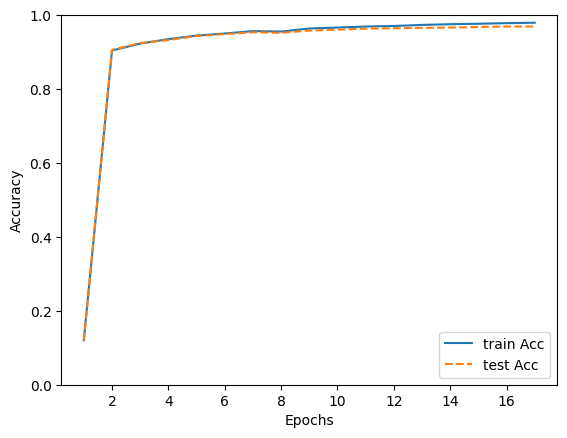

In [ ]:
'''
4장에서 구현한 2층 신경망을 오차역전파법을 사용하여 학습을 구현함.
'''
class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

        # 계층 생성 - 인스턴스를 생성하고 layers 딕션너리에 순차적으로 저장
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])

        self.lastLayer = SoftmaxWithLoss()
        # Affine1 -> Relu1 -> Affine2 -> Softmax 의 레이어를 갖는 신경망을 구현.

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        # Affine1 -> Relu1 -> Affine2 순으로 forward() 실행
        return x

    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    # x : 입력 데이터, t : 정답 레이블
    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1                                # 역전파의 초기 신호를 1으로 설정,
        dout = self.lastLayer.backward(dout)    # 역전파를 계산하여 해당 레이어 클래스에 기울기(Gradient)를 저장.

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
            # Affine2 -> Relu1 -> Affine1 순으로 backward() 실행

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db
        return grads


(x_train, t_train), (x_test, t_test) = tf.keras.datasets.mnist.load_data()

t_train=tf.keras.utils.to_categorical(t_train, num_classes=10)
t_test=tf.keras.utils.to_categorical(t_test, num_classes=10)

x_train=x_train.reshape(60000,-1)
x_train = x_train.astype(np.float32)
x_train /= 255.0

x_test=x_test.reshape(10000,-1)
x_test = x_test.astype(np.float32)
x_test /= 255.0

print("x_train :", x_train.shape)
print("t_train :", t_train.shape)
print("x_test :", x_test.shape)
print("t_test :", t_test.shape)

#print(x_train[0])


network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)


iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    # 기울기 계산
    grad = network.gradient(x_batch, t_batch)

    # 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]    # 학습 후 계산한 기울기(Gradient)로 경사하강법을 사용하여 학습.

    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("epoch :", int(i / iter_per_epoch))
        print("train_acc : %.4f" % (train_acc))
        print("test_acc : %.4f" % (test_acc))
        print()

# draw acc graph.
x = np.arange(1, len(train_acc_list) + 1)
plt.plot(x, train_acc_list, label='train Acc')
plt.plot(x, test_acc_list, label='test Acc', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1.0)
plt.legend(loc="lower right")
plt.show()